# Road Segmentation Project

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import os,sys
from PIL import Image
from skimage import feature
from skimage import color
from skimage.transform import (hough_line, hough_line_peaks,probabilistic_hough_line)
import scipy

### Define helper functions

In [2]:
# helper feature building functions
def img_crop(im, w, h):
    # get list of patches from the image with size specified by w and h
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3 # is image in 2D?
    for i in range(0,imgheight,h): # loop across height in steps equal to your height patch size
        for j in range(0,imgwidth,w):  # loop across width in steps equal to your width patch size
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def value_to_class(v,foreground_threshold):
    """Decide whether a given patch is background or foreground
    v: mean of groundtruth image (1 x 16) """
    df = np.sum(v) # total mean of groundtruth image --> equivalent to percentage of pixels being in foreground
    if df > foreground_threshold:
        return 1 # patch in foreground 
    else:
        return 0 # patch in background

In [3]:
# helper visualization functions
def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0] # width
    h = gt_img.shape[1] # height
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8) #gt_image with three channels to match img
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8 # create the three channels identically
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg


def label_to_img(imgwidth, imgheight, w, h, labels):
    """ Convert array of labels to an image
    w: patch width
    h: patch size"""
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx] # fill all pixels in a given patch with the same label
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    """Overlay image to groundtruth image"""
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

In [4]:
# helper import/export functions
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

### Load and visualize images

In [5]:
# Load set training images
root_dir = "Data/training/"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files) # n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]

Loading 100 images


In [6]:
# Load set of groundtruth images
gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

Loading 100 images


Image size = 400,400


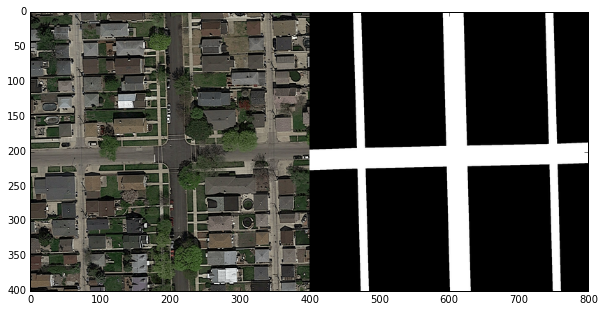

In [7]:
# Show first image and its groundtruth image
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1])) # Print image size
cimg = concatenate_images(imgs[0], gt_imgs[0]) # concatenate image and groudntruth
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

### Build features

In [8]:
def extract_features(img,n,hough):
    """Extract n-dimensional features consisting of average gray color as well as variance
    img: image patch
    n: number of features to use(either 2 or 6)
    hough: boolean, include hough transform feature"""
    
    if n ==2:
        # Two features: mean and variance across all RGB layers
        feat_m = np.mean(img) 
        feat_v = np.var(img) 
        feat = np.append(feat_m, feat_v) # (1 x 2) 
    elif n==6:     
        # Six features: mean and variance across each of the three RGB layers
        feat_m = np.mean(img, axis=(0,1))
        feat_v = np.var(img, axis=(0,1)) 
        feat = np.append(feat_m, feat_v) # feat will be (1 x 6)      
    if hough:
        # Hough transform
        gray_img = color.rgb2gray(img)   # convert image to grayscale
        edges_img = feature.canny(gray_img) # use canny edge detector
        h, theta, d = hough_line(edges_img) # compute hough transform of edges image
        h_std = np.std(np.std(h,axis = 0))
        feat = np.append(feat,h_std) 
    return feat

def extract_img_features(filename,hough):
    """Extract features for a given image"""
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([extract_features(img_patches[i],num_features,hough) for i in range(len(img_patches))])
    return X # has shape (n * number of patches x number of features)

In [9]:
def prepareFeatures(n_features,patch_size,n,foreground_threshold,print_= True,hough = False):
    """Function to prepare features
    ## inputs:
        n_features = number of features to add to the model (only 2 or 6 so far)
        n = indexes of images to use for the training
    ## outputs: 
        X = feature matrix
        Y = labels vector"""
    
    # Extract patches from input images
    img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in np.arange(n[0],n[1])]
    gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in np.arange(n[0],n[1])]

    # Linearize list of patches
    img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    X = np.asarray([extract_features(img_patches[i],num_features,hough) for i in range(len(img_patches))])
    Y = np.asarray([value_to_class(np.mean(gt_patches[i]),foreground_threshold) for i in range(len(gt_patches))])
    
    # Normalize the features
    X_maxs = np.max(X,axis = 0)
    X = X/X_maxs
    
    # Print feature statistics
    if print_:
        print('Computed ' + str(X.shape[0]) + ' features') # corresponds to n * number of patches
        print('Feature dimension = ' + str(X.shape[1]))
        print('Number of classes = ' + str(np.max(Y) + 1))
        Y0 = [i for i, j in enumerate(Y) if j == 0]
        Y1 = [i for i, j in enumerate(Y) if j == 1]
        print('Class 0: ' + str(len(Y0)) + ' samples')
        print('Class 1: ' + str(len(Y1)) + ' samples') 
    
    return X,Y

## Classifiers Training

Since we had a limited number of Kaggle submissions per day, we trained our model in 80% of the images, and tested in the 20 remaining ones. For those, we calculated the true positive rate and the F1 score, as measures of performance of our model.

In [10]:
def trainingErrorClassifier(X_test,Y_test,classifier,classifier_type,test_image,hough = False,plot_=True):
    """Test classifier on training data not used for training
    You obtain true positive rate, F1 metric and visualization"""
    
    # Predict on the training set
    Z = classifier.predict(X_test) # gives 0 / 1 labels for all the training patches

    # Get non-zeros in prediction and grountruth arrays
    Zn = np.nonzero(Z)[0] # get index of predicted foreground patches
    Yn = np.nonzero(Y_test)[0] # get index of real foreground patches

    # Get metrics on the accuracy of the model
    TPR = len(list(set(Yn) & set(Zn))) / float(len(Z)) # calculate the true positive rate
    # set(Yn) & set(Zn) gives the list of coincident indexes in Yn and Zn
    print(classifier_type)
    print('True positive rate = %.4f'%TPR)
    f1 = metrics.f1_score(Y_test, Z, average='binary')  # Calculate F1 metric of our classification 
    print('F1 metric = %.4f'%f1)
    
    if plot_:
        #Make plots for a single image
        img_idx = test_image
        Xi = extract_img_features(image_dir + files[img_idx],hough)
        Zi = classifier.predict(Xi)
        w = gt_imgs[img_idx].shape[0] # image width
        h = gt_imgs[img_idx].shape[1] # image height
        predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
    
        plt.figure(figsize = [10,5])
        ax = plt.subplot(131)
        plt.imshow(imgs[img_idx])
        plt.title('Original')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax = plt.subplot(132)
        plt.imshow(gt_imgs[img_idx],cmap='Greys_r')
        plt.title('Groundtruth')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax = plt.subplot(133)
        plt.imshow(predicted_im,cmap='Greys_r')
        plt.title('Predicted')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Logistic Regression Classifier

In [11]:
# Build the features for training and test data
num_features = 6 # currently only 2 or 6 are valid options
patch_size = 16 # each patch is 16*16 pixels
n_training_images = 80 # Only use n images for training
foreground_threshold = 0.25 # if mean of image > threshold, 1 assigned for foreground patch

print('Training Data')
X_train,Y_train = prepareFeatures(num_features,patch_size,[0,n_training_images],foreground_threshold,hough = False)

print('\nTraining Data (not used for training)')
X_test,Y_test = prepareFeatures(num_features,patch_size,[n_training_images,len(imgs)],foreground_threshold,hough = False)

Training Data
Computed 50000 features
Feature dimension = 6
Number of classes = 2
Class 0: 37115 samples
Class 1: 12885 samples

Training Data (not used for training)
Computed 12500 features
Feature dimension = 6
Number of classes = 2
Class 0: 9194 samples
Class 1: 3306 samples


LOGISTIC REGRESSION CLASSIFIER
True positive rate = 0.1663
F1 metric = 0.4602


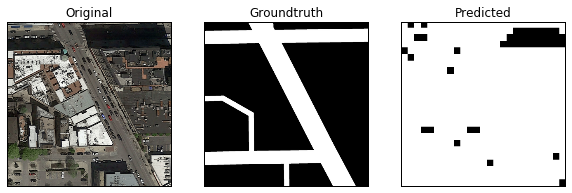

In [12]:
# Train the logistic regression classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(C=1e5, class_weight="balanced") # C --> regularization strength (small value, stronger regularization)
classifier.fit(X_train, Y_train)

# Test classifier on training data left aside (not used for training)
test_image = 82 # image to plot
trainingErrorClassifier(X_test,Y_test,classifier,'LOGISTIC REGRESSION CLASSIFIER',test_image,hough = False)

### Random Forest Classifier

RANDOM FOREST CLASSIFIER
True positive rate = 0.0870
F1 metric = 0.4289


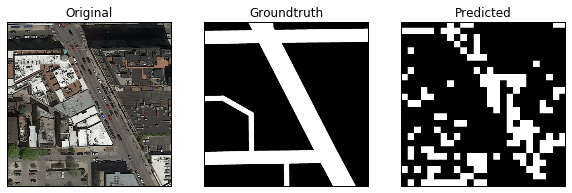

In [13]:
#### Train a basic random forest classifier
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train, Y_train)

# Test classifier on training data left aside (not used for training)
test_image =82 # image to plot
trainingErrorClassifier(X_test,Y_test,classifier,'RANDOM FOREST CLASSIFIER',test_image, hough = False)

RANDOM FOREST CLASSIFIER WITH 2 FEATURES
True positive rate = 0.0613
F1 metric = 0.3089


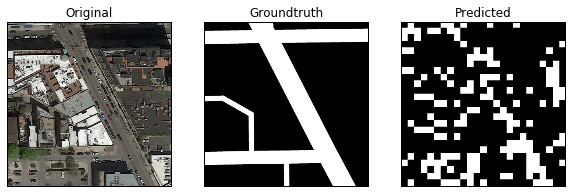

In [14]:
#### Train random forest classifier with other parameters
# 2 features
# patch size of 16x16

# Build features
num_features = 2
patch_size = 16
n_training_images = 80
X_train,Y_train = prepareFeatures(num_features,patch_size,[0,n_training_images],foreground_threshold,hough = False, print_=False)
X_test,Y_test = prepareFeatures(num_features,patch_size,[n_training_images,len(imgs)],foreground_threshold,hough = False,print_=False)

# Build and train classifier
num_trees = 70
tree_depth = 10000
classifier = RandomForestClassifier(n_estimators = num_trees, max_depth = tree_depth)
classifier.fit(X_train, Y_train)

# Test classifier on training data
test_image= 82  
trainingErrorClassifier(X_test,Y_test,classifier,'RANDOM FOREST CLASSIFIER WITH 2 FEATURES',test_image,hough = False)

RANDOM FOREST CLASSIFIER WITH 7 FEATURES
True positive rate = 0.1048
F1 metric = 0.4820


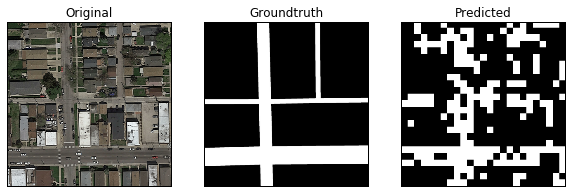

In [15]:
#### Train random forest classifier with other parameters
# 7 features
# patch size of 16x16

# Build features
num_features = 6
patch_size = 16
n_training_images = 90
X_train,Y_train = prepareFeatures(num_features,patch_size,[0,n_training_images],foreground_threshold,hough = True, print_=False)
X_test,Y_test = prepareFeatures(num_features,patch_size,[n_training_images,len(imgs)],foreground_threshold,hough = True,print_=False)

# Build and train classifier
num_trees = 70
tree_depth = 10000
classifier = RandomForestClassifier(n_estimators = num_trees, max_depth = tree_depth)
classifier.fit(X_train, Y_train)

# Test classifier on training data
test_image= 92  
trainingErrorClassifier(X_test,Y_test,classifier,'RANDOM FOREST CLASSIFIER WITH 7 FEATURES',test_image,hough = True)

## Prepare submission on test images

#### Prepare submission

In [16]:
# Load test images
image_filenames = []
n_test = 50
for i in range(1, n_test+1):
    image_filename = 'data/test/test_%d' % i + '/test_%d' % i + '.png'
    image_filenames.append(image_filename)

imgs_test = [load_image(image_filename) for image_filename in image_filenames]
w = imgs_test[0].shape[0]
h = imgs_test[0].shape[1]

In [17]:
#### Train final random forest classifier and prepare for submission

# Build features
num_features = 6
patch_size = 16
n_training_images = 100
hough_on = True
X_train,Y_train = prepareFeatures(num_features,patch_size,[0,n_training_images],foreground_threshold,hough =hough_on, print_=False)

# Build and train classifier on all images
num_trees = 70
tree_depth = 10000
classifier = RandomForestClassifier(n_estimators = num_trees, max_depth = tree_depth)
classifier.fit(X_train, Y_train)

# Prepare features on test images
img_patches = [img_crop(imgs_test[i], patch_size, patch_size) for i in range(n_test)]
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
X_test = np.asarray([extract_features(img_patches[i],num_features,hough_on) for i in range(len(img_patches))])
X_test_maxs = np.max(X_test,axis = 0)
X_test = X_test/X_test_maxs

# Test classifier
Z_test= classifier.predict(X_test)

In [18]:
# Save submission
from mask_to_submission import *
n_patches_per_image = len(img_patches)/n_test
for i in range(0,n_test):
    im_labels = Z_test[int(n_patches_per_image*i):int(n_patches_per_image*(i+1))]
    # Transform the patches into a complete black and white image
    predicted_im = label_to_img(w, h, patch_size, patch_size, im_labels)
    j = i + 1
    # Save each image into a folder prediction 
    scipy.misc.imsave('data/prediction_RFC/resultImage_' + '%.3d' % j + '.png', predicted_im)
submission_filename = 'data/RFC_submission_hough' + str(hough_on) + '_features' + str(num_features) + '_patch' + str(patch_size) + '_trees' + str(num_trees) + '.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = 'data/prediction_RFC/resultImage_' + '%.3d' % i + '.png'
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)

print('Results saved for submission.')

Results saved for submission.
